In [8]:
from src.config import filepaths
from src.utils import construct_sparse_adj_mat, load_json
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact

In [2]:
def plot_cdf(ax, data, flip_axes=False, color='black', label=''):
    data = sorted(data)
    ycdf = np.arange(1, len(data) + 1) / len(data)

    if flip_axes:
        ax.plot(ycdf, data, color=color, label=label)
    else:
        ax.plot(data, ycdf, color=color, label=label)

In [3]:
smfp = filepaths['artifacts_sim_mats']
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'

adj, idx_sample, idx_feature = construct_sparse_adj_mat(dataset, toc)
krs = load_json(filepaths['data_sprhea'] / f"{toc}.json")
rules = pd.read_csv(filepaths['data'] / "minimal1224_all_uniprot.tsv", sep='\t', )
rules.set_index('Name', inplace=True)

rxn_sim_metrics = [
    'bag_of_molecules_reactions',
    'rc_agg_r2_reactions',
    'rc_agg_r3_reactions',
    'rc_agg_r4_reactions',
    "rcmcs",
    "mcs",
    "tanimoto"
]

rxn_sim_mats = {name: np.load(smfp / f"{dataset}_{toc}_{name}.npy")
                for name in rxn_sim_metrics}

Constructing sprhea:v3_folded_pt_ns sparse adjacency matrix


In [61]:
rng = np.random.default_rng(seed=1234)
filter_zero_rcmcs = True
n_points = 10_000
n = rxn_sim_mats['rcmcs'].shape[0]
if filter_zero_rcmcs:
    idxs = np.vstack(np.nonzero(rxn_sim_mats['rcmcs'])).T
    idxs = idxs[idxs[:, 0] != idxs[:, 1]]
else:
    idxs = np.vstack(np.triu_indices(n, k=1)).T
sel = rng.choice(idxs.shape[0], size=n_points, replace=False)
idxs = idxs[sel]
i, j = idxs[:, 0], idxs[:, 1]

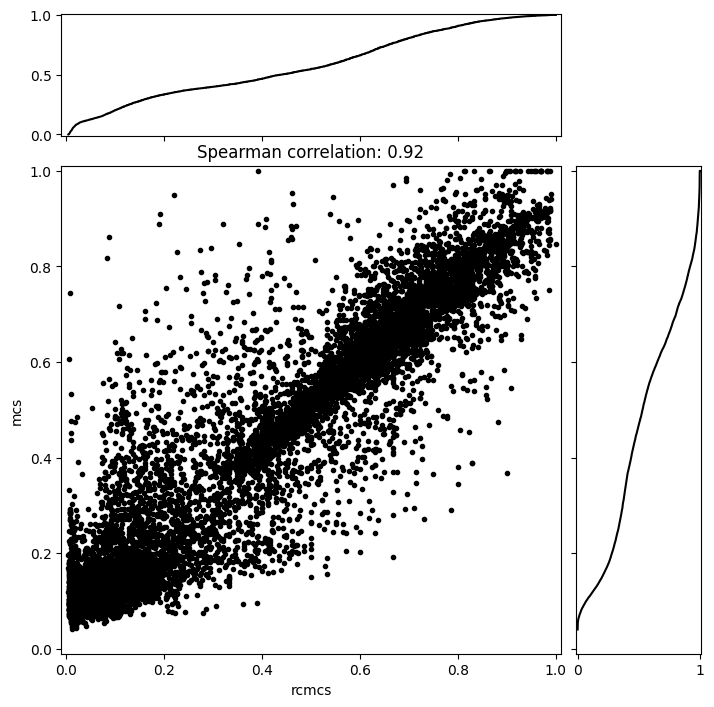

In [66]:
sim_mats = ['rcmcs', 'mcs']
mean_sub_scl = False
data = []
for sm in sim_mats:
    data.append(rxn_sim_mats[sm][i, j])

x, y = data
if mean_sub_scl:
    x -= x.mean()
    x /= x.std()
    y -= y.mean()
    y /= y.std()

res = spearmanr(x, y)

# Def figure
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.1)

# Create the Axes
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Style
ax.set_title(f"Spearman correlation: {res.statistic:.2f}")
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histx.set_ylim(-0.01, 1.01)
ax_histy.set_xlim(-0.01, 1.01)
ax.set_xlabel(sim_mats[0])
ax.set_ylabel(sim_mats[1])
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)

# Plot
ax.plot(x, y, '.', color='black')
plot_cdf(ax_histx, x)
plot_cdf(ax_histy, y, flip_axes=True)
plt.show()

In [54]:
sel_set = set(np.where(x > 0.5)[0])  & set(np.where(y == 0.0)[0])
sel = sorted(sel_set)
pair_sel = widgets.Dropdown(
    options=sel,
    value=sel[0]
)

@interact
def display_pair(idx=pair_sel):
    rid1 = idx_feature[i[idx]]
    rid2 = idx_feature[j[idx]]
    rxn1 = krs[idx_feature[i[idx]]]
    rxn2 = krs[idx_feature[j[idx]]]
    ec1 = {e['ec'] for e in rxn1['enzymes']}
    ec2 = {e['ec'] for e in rxn2['enzymes']}
    print(f"{sim_mats[0]}: {x[idx]:.2}", f"{sim_mats[1]}: {y[idx]:.2f}")
    print(f"Rxn: {rid1} - > Rules: {rxn1['min_rules']}, ECs: {ec1}")
    display(AllChem.ReactionFromSmarts(rxn1['smarts'], useSmiles=True))
    print(f"Rxn: {rid2} - > Rules: {rxn2['min_rules']}, ECs: {ec2}")
    display(AllChem.ReactionFromSmarts(rxn2['smarts'], useSmiles=True))

IndexError: list index out of range

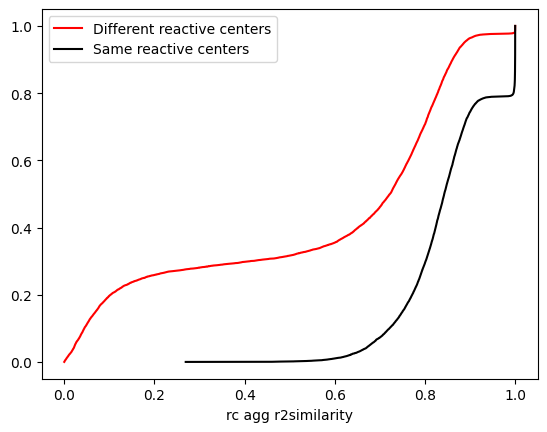

In [7]:
# Plot cdf of embedding sims for each bucket of 
# zero and nonzero trad sim scores

rng = np.random.default_rng(seed=1234)
sm_name = "rc_agg_r2_reactions"
sim_mat = rxn_sim_mats[sm_name]
n_points = 10_000
n = rxn_sim_mats['rcmcs'].shape[0]

nonzero_rcmcs_idxs = np.vstack(np.nonzero(rxn_sim_mats['rcmcs'])).T
nonzero_rcmcs_idxs = nonzero_rcmcs_idxs[nonzero_rcmcs_idxs[:, 0] != nonzero_rcmcs_idxs[:, 1]] # Ensure i != j
zero_rcmcs_idxs = np.argwhere(rxn_sim_mats['rcmcs'] == 0)
downsample = lambda x : x[rng.choice(x.shape[0], size=n_points, replace=False)]

fig, ax = plt.subplots()

# Style
colors = ['red', 'black']
labels = ['Different reactive centers', 'Same reactive centers']
ax.set_xlabel(" ".join(sm_name.split("_")[:-1]) + "similarity")


# Plot
foo = []
for i, idxs in enumerate([zero_rcmcs_idxs, nonzero_rcmcs_idxs]):
    idxs = downsample(idxs)
    data = sim_mat[idxs[:, 0], idxs[:, 1]]
    plot_cdf(ax, data, color=colors[i], label=labels[i])


ax.legend()
plt.show()